#具有视觉注意力的图像字幕

给定类似下面示例的图像，我们的目标是生成一个标题，例如“冲浪者骑在海浪上”。
![替代文字](https://tensorflow.org/images/surf.jpg)
为此，您将使用基于注意力的模型，该模型使我们能够在生成字幕时查看模型重点关注图像的哪些部分。

![替代文字](https://tensorflow.org/images/imcap_prediction.png)
该笔记本是端到端的示例。运行笔记本时，它会下载[MS-COCO](http://cocodataset.org/#home)数据集，使用Inception V3进行预处理和缓存图像的子集，训练编码器-解码器模型，并使用训练后的模型在新图像上生成字幕。

在此示例中，您将在相对少量的数据上训练模型-前30,000个标题用于大约20,000个图像（因为数据集中每个图像有多个标题）。

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import,division,print_function,unicode_literals

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

#下载并准备MS-COCO数据集
您将使用[MS-COCO](http://cocodataset.org/#home)数据集来训练我们的模型。数据集包含超过82,000张图像，每个图像至少具有5个不同的标题注释。下面的代码自动下载并提取数据集。

**注意：提前大量下载。**您将使用训练集，它是一个13GB的文件。

In [4]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

#下载图片文件
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.')+image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 824s 0us/step


##可选：限制训练集的大小
为了加快本教程的培训速度，您将使用30,000个字幕的子集及其对应的图像来训练我们的模型。选择使用更多数据将提高字幕质量。

In [0]:
#读取json文件
with open(annotation_file,'r') as f:
  annotations = json.load(f)

## Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
  caption = '<start> ' + annot['caption'] + ' <end>'
  image_id = annot['image_id']
  full_coco_image_path = PATH + 'COCO_train2014_' +'%012d.jpg' % (image_id)

  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)

#随机打乱图像和说明数据
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

#只选前30000条数据
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]



In [6]:
#查看一下数据
len(train_captions), len(all_captions)

(30000, 414113)

##使用InceptionV3预处理图像
接下来，您将使用InceptionV3（在Imagenet上进行了预训练）对每个图像进行分类。您将从最后一个卷积层提取特征。

首先，您将通过以下方式将图像转换为InceptionV3的预期格式：

* 将图片大小调整为299px x 299px
* 使用`preprocess_input`方法对**图像**进行**预处理**以规范化图像，使其包含-1到1范围内的像素，该像素与用于训练InceptionV3的图像格式匹配。

In [0]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img,channels=3)
  img = tf.image.resize(img,(299,299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

##初始化InceptionV3并加载预训练的Imagenet权重
现在，您将创建一个tf.keras模型，其中输出层是InceptionV3体系结构中的最后一个卷积层。该层的输出形状为`8x8x2048`。您使用最后一个卷积层，因为在此示例中您正在使用注意力。您在训练过程中不执行此初始化，因为它可能会成为瓶颈。

* 您通过网络转发每个图像，并将得到的矢量存储在字典中（image_name-> feature_vector）。
* 所有图像通过网络传递后，您可以对词典进行腌制并将其保存到磁盘。

In [8]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 8s 0us/step


##缓存从InceptionV3中提取的功能
您将使用InceptionV3预处理每个图像，并将输出缓存到磁盘。将输出缓存在RAM中会更快，但也会占用大量内存，每个图像需要8 * 8 * 2048个浮点数。在撰写本文时，这超出了Colab的内存限制（当前为12GB内存）。

使用更复杂的缓存策略（例如，通过分片映像以减少随机访问磁盘I / O）可以提高性能，但这将需要更多代码。

使用GPU在Colab中运行缓存大约需要10分钟。如果您想查看进度条，可以：

1. 安装tqdm：
```
!pip install -q tqdm
```
2. 导入tqdm：
```
from tqdm import tqdm
```
3. 更改以下行：
```
for img, path in image_dataset:
```
至：
```
for img, path in tqdm(image_dataset):
```

In [0]:
!pip install -q tqdm

In [0]:
from tqdm import tqdm

In [11]:
# Get unique images
encode_train = sorted(set(img_name_vector))

#Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0],-1,batch_features.shape[3]))
  
  for bf,p in zip(batch_features,path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


1622it [07:08,  2.56it/s]


预处理字幕并将其标记化
* 首先，您将标记标题（例如，通过分割空格）。这为我们提供了数据中所有唯一单词的词汇表（例如，“冲浪”，“足球”等）。
* 接下来，将词汇量限制为前5,000个单词（以节省内存）。您将所有其他单词替换为令牌“ UNK”（未知）。
* 然后，您创建单词到索引和索引到单词的映射。
* 最后，将所有序列填充为与最长序列相同的长度。

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
#Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
#Calculates the max_length, which is used to store the attention weigths
max_length = calc_max_length(train_seqs)

##将数据分为训练和测试

In [0]:
#将数据分成训练和测试  80/20
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

##创建一个tf.data数据集进行训练
我们的图像和标题已准备就绪！接下来，让我们创建一个tf.data数据集以用于训练我们的模型。

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [0]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train,cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]
),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

###模型
有趣的事实：以下解码器与“**带有注意的神经机器翻译** ”示例中的解码器相同。

该模型的体系结构受到[Show，Attend和Tell](https://arxiv.org/pdf/1502.03044.pdf)论文的启发。

* 在此示例中，您从InceptionV3的较低卷积层中提取要素，从而为我们提供了形状为（8，8，2048）的向量。
* 您将其压缩为（64，2048）形状。
* 然后，此矢量通过CNN编码器（由单个完全连接层组成）传递。
* RNN（此处为GRU）参与图像预测下一个单词。

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    #context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features 
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
  # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
      super(CNN_Encoder, self).__init__()
      # shape after fc == (batch_size, 64, embedding_dim)
      self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
      x = self.fc(x)
      x = tf.nn.relu(x)
      return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *=mask

  return tf.reduce_mean(loss_)

###检查站

In [0]:
checkpoint_path = './checkpoints/train'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

##训练
* 您提取存储在各个.npy文件中的功能，* 然后将这些功能通过编码器。
* 编码器输出的隐藏状态（初始化为0）和* 解码器输入（即开始令牌）将传递到解码器。
* 解码器返回预测和解码器隐藏状态。
* 然后将解码器隐藏状态传递回模型，并使用预测来计算损耗。
* 使用教师强制决定解码器的下一个输入。
* 教师强迫是将目标单词作为下一个输入传递给解码器的技术。
* 最后一步是计算梯度并将其应用于优化器和反向传播。

In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [32]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9317
Epoch 1 Batch 100 Loss 1.1945
Epoch 1 Batch 200 Loss 0.9405
Epoch 1 Batch 300 Loss 0.8500
Epoch 1 Loss 1.038309
Time taken for 1 epoch 391.65508127212524 sec

Epoch 2 Batch 0 Loss 0.8408
Epoch 2 Batch 100 Loss 0.7680
Epoch 2 Batch 200 Loss 0.7853
Epoch 2 Batch 300 Loss 0.7625
Epoch 2 Loss 0.790010
Time taken for 1 epoch 357.4610261917114 sec

Epoch 3 Batch 0 Loss 0.6982
Epoch 3 Batch 100 Loss 0.7966
Epoch 3 Batch 200 Loss 0.7064
Epoch 3 Batch 300 Loss 0.6814
Epoch 3 Loss 0.721915
Time taken for 1 epoch 349.08723878860474 sec

Epoch 4 Batch 0 Loss 0.6920
Epoch 4 Batch 100 Loss 0.7057
Epoch 4 Batch 200 Loss 0.7250
Epoch 4 Batch 300 Loss 0.6905
Epoch 4 Loss 0.677674
Time taken for 1 epoch 345.68010997772217 sec

Epoch 5 Batch 0 Loss 0.6316
Epoch 5 Batch 100 Loss 0.6685
Epoch 5 Batch 200 Loss 0.6003
Epoch 5 Batch 300 Loss 0.5946
Epoch 5 Loss 0.643094
Time taken for 1 epoch 342.13243556022644 sec

Epoch 6 Batch 0 Loss 0.5602
Epoch 6 Batch 100 Loss 0.6580
Epoch 6 

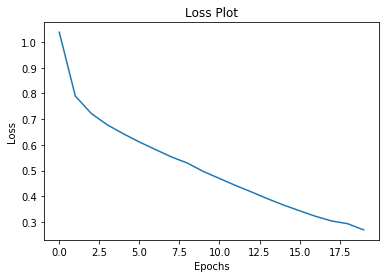

In [34]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

##字幕！
* 评估功能与训练循环类似，不同之处在于，此处不使用教师强制。在每个时间步长，解码器的输入是其先前的预测以及隐藏状态和编码器输出。
* 在模型预测结束标记时停止预测。
* 并存储每个步骤的注意力权重。

In [0]:
def evaluate(image):
  attention_plot = np.zeros((max_length, attention_features_shape))

  hidden = decoder.reset_state(batch_size=1)

  temp_input = tf.expand_dims(load_image(image)[0],0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],-1, img_tensor_val.shape[3]))

  features = encoder(img_tensor_val)

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
  result = []

  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    result.append(tokenizer.index_word[predicted_id])

    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot

    dec_input = tf.expand_dims([predicted_id],0)

  attention_plot = attention_plot[:len(result),:]
  return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(10,10))

  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[1],(8,8))
    ax = fig.add_subplot(len_result//2, len_result//2, l+1)
    ax.set_title(result[1])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()

Real Caption:  <start> a baseball player getting ready to swing the bat <end>
Prediction Caption:  a baseball player holding a bat while his bat while holding a baseball bat holding a base swinging a bat <end>


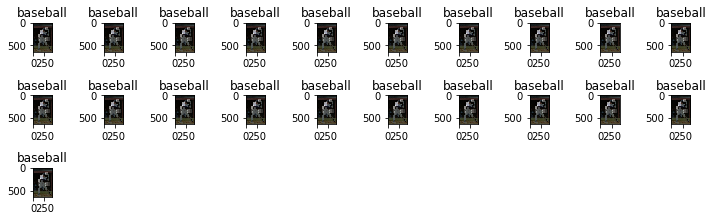

In [37]:
# captions on the validation set 
rid = np.random.randint(0,len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption: ',real_caption)
print('Prediction Caption: ', ' '.join(result))
plot_attention(image, result, attention_plot)

##在自己的图像上尝试
有趣的是，下面我们提供了一种方法，您可以用我们刚刚训练的模型为自己的图像加上标题。请记住，它是在相对少量的数据上进行训练的，并且您的图像可能与训练数据不同（因此请准备好奇怪的结果！）

65536/64400 [==============================] - 0s 4us/step
Prediction Caption: a man is riding a wave on a surfboard <end>


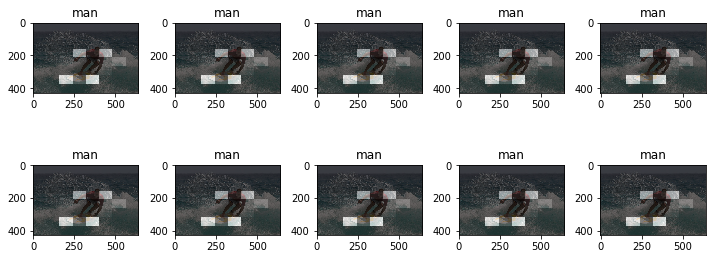

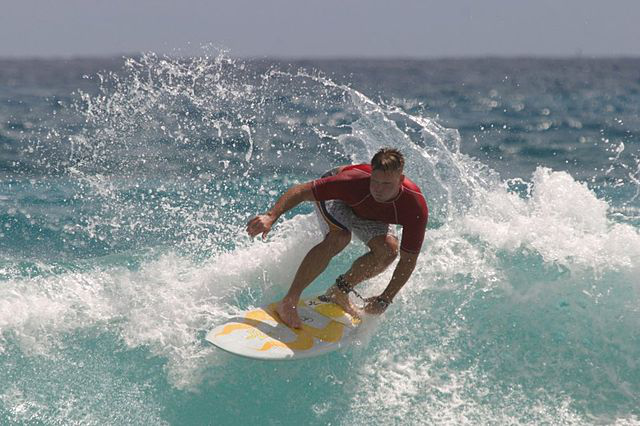

In [38]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)